In [2]:
import datetime
import yfinance as yf
import statsmodels.tsa.stattools as sm
import seaborn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = sm.coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [4]:
tick = ['AAPL', 'ADBE', 'ORCL', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM', 'SPY']

In [6]:
tickers = yf.Tickers('msft aapl goog adbe orcl ebay qcom hpq jnpr amd ibm spy')

In [7]:
df = pd.DataFrame()
for s in tick:
    closing = tickers.tickers[s].history(start='2020-01-01', end=None)['Close']
    df[s] = closing

In [8]:
df = df.dropna()

In [9]:
scores, pvalues, pairs = find_cointegrated_pairs(data=df)

In [10]:
s1 = df['ORCL']
s2 = df['MSFT']

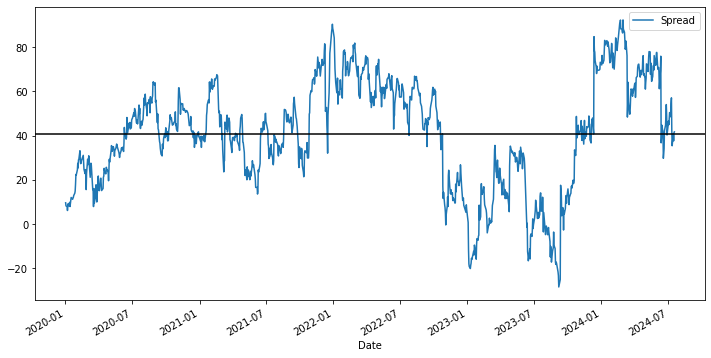

In [11]:
s1 = sm.add_constant(s1)
results = sm.OLS(s2,s1).fit()
s1 = s1['ORCL']
b = results.params['ORCL']

spread = s2 - b * s1
spread.plot(figsize=(12,6))
plt.axhline(spread.mean(), color='black')
#plt.xlim('2013-01-01', '2018-01-01')
plt.legend(['Spread'])


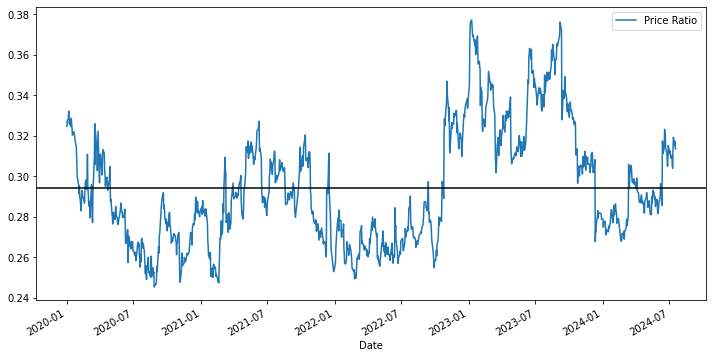

In [12]:
ratio = s1/s2
ratio.plot(figsize=(12,6))
plt.axhline(ratio.mean(), color='black')
plt.legend(['Price Ratio'])

In [13]:
def z_score(series):
    return (series - series.mean()) / np.std(series)

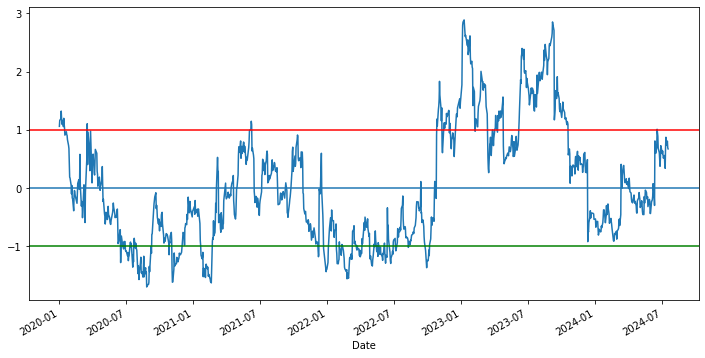

In [14]:
z_score(ratio).plot(figsize=(12,6))
plt.axhline(z_score(ratio).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.show()

In [15]:
ratios = df['ORCL']/df['MSFT']
len(ratios) * 0.7

800.0999999999999

In [16]:
train = ratios[:799]
test = ratios[799:]

In [17]:
ratio_mavg5 = train.rolling(window=5, center=False).mean()
ratio_mavg60 = train.rolling(window=60, center=False).mean()
std_60 = train.rolling(window=60, center=False).std()

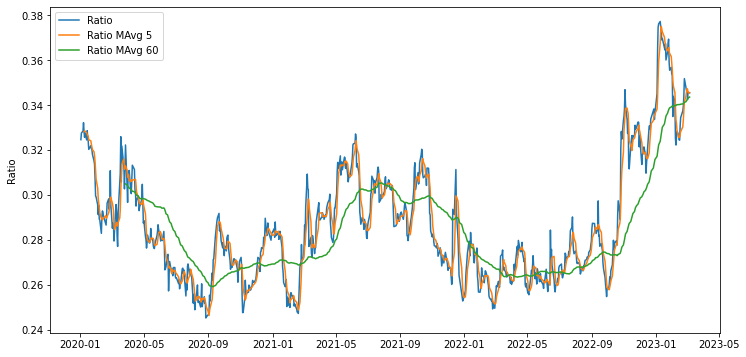

In [18]:
plt.figure(figsize=(12,6))
plt.plot(train.index, train.values)
plt.plot(ratio_mavg5.index, ratio_mavg5.values)
plt.plot(ratio_mavg60.index, ratio_mavg60.values)
plt.legend(['Ratio', 'Ratio MAvg 5', 'Ratio MAvg 60'])
plt.ylabel('Ratio')
plt.show()

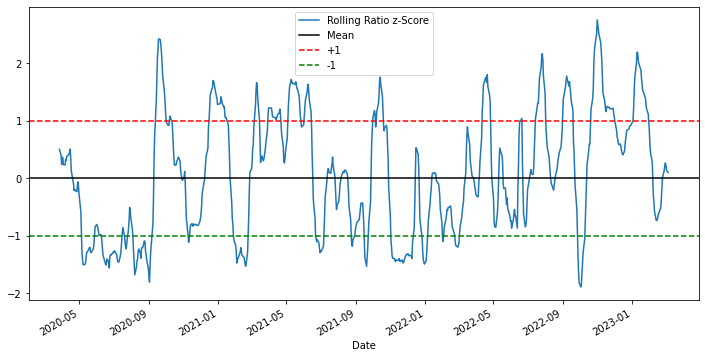

In [19]:
z_5_60 = (ratio_mavg5 - ratio_mavg60) / std_60

plt.figure(figsize=(12,6))
z_5_60.plot()
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

In [20]:
len(train)

799

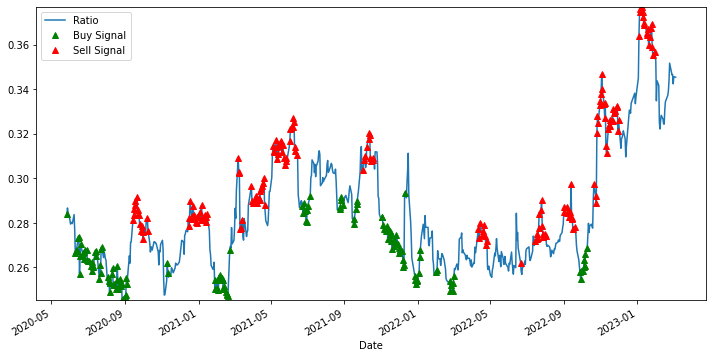

In [29]:
plt.figure(figsize=(12,6))
train[100:].plot()
buy = train.copy()
sell = train.copy()
buy[z_5_60 > -1] = 0
sell[z_5_60 < 1] = 0

buy[100:].plot(color='g', linestyle='None', marker='^')
sell[100:].plot(color='r', linestyle='None', marker='^')

x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratios.min(), ratios.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()